# Stroke Prediction MVP

## Cleaning data and creating dummy variables

In [3]:
import pandas as pd
import numpy as np

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, roc_auc_score, precision_score, recall_score, accuracy_score
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier

import seaborn as sns
import matplotlib.pyplot as plt

In [4]:
df = pd.read_csv('healthcare-dataset-stroke-data.csv') 

In [5]:
df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


In [7]:
df.gender.value_counts()

Female    2994
Male      2115
Other        1
Name: gender, dtype: int64

In [8]:
#drop the one missing value in 'gender'
df = df[df['gender']!='Other']

In [9]:
df.smoking_status.value_counts()

never smoked       1892
Unknown            1544
formerly smoked     884
smokes              789
Name: smoking_status, dtype: int64

In [10]:
#mapping categorical values to numeric
df['smoking_map']=df.smoking_status.map({'never smoked':0,'formerly smoked':1,'smokes':2})

In [11]:
#get dummy variables
genderdummy=pd.get_dummies(df["gender"], drop_first=True)
marrieddummy=pd.get_dummies(df["ever_married"], prefix="married", drop_first=True)
workdummy=pd.get_dummies(df["work_type"], drop_first=True)
residencedummy=pd.get_dummies(df["Residence_type"], drop_first=True)

In [12]:
colstokeep=["age","hypertension","heart_disease",'avg_glucose_level','bmi','stroke','smoking_map']

In [13]:
dummydf = df[colstokeep].join(genderdummy).join(marrieddummy).join(workdummy).join(residencedummy)

In [14]:
dummydf.columns

Index(['age', 'hypertension', 'heart_disease', 'avg_glucose_level', 'bmi',
       'stroke', 'smoking_map', 'Male', 'married_Yes', 'Never_worked',
       'Private', 'Self-employed', 'children', 'Urban'],
      dtype='object')

In [15]:
#imputing missing values by KNNimputation
imputer = KNNImputer(n_neighbors=1)
df_filled=imputer.fit_transform(dummydf)

In [16]:
df_filled=pd.DataFrame(df_filled,columns=dummydf.columns)

In [17]:
#convert smoking_status back to categorical and to dummies
smokingdummy=pd.get_dummies(df_filled["smoking_map"], drop_first=True)
smokingdummy.rename(columns={1:'formerly smoked', 2:'smokes'}, inplace=True)
df_filled=df_filled.drop('smoking_map', axis=1).join(smokingdummy)

In [18]:
df_filled.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5109 entries, 0 to 5108
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   age                5109 non-null   float64
 1   hypertension       5109 non-null   float64
 2   heart_disease      5109 non-null   float64
 3   avg_glucose_level  5109 non-null   float64
 4   bmi                5109 non-null   float64
 5   stroke             5109 non-null   float64
 6   Male               5109 non-null   float64
 7   married_Yes        5109 non-null   float64
 8   Never_worked       5109 non-null   float64
 9   Private            5109 non-null   float64
 10  Self-employed      5109 non-null   float64
 11  children           5109 non-null   float64
 12  Urban              5109 non-null   float64
 13  formerly smoked    5109 non-null   uint8  
 14  smokes             5109 non-null   uint8  
dtypes: float64(13), uint8(2)
memory usage: 529.0 KB


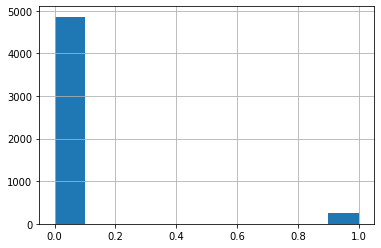

In [19]:
#check class imbalance
df_filled.stroke.hist()
plt.show()

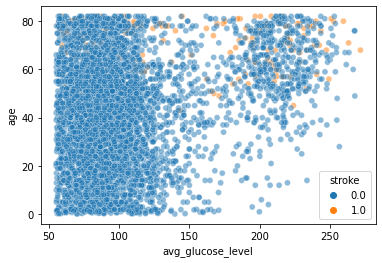

In [20]:
#check class imbalance
sns.scatterplot(x="avg_glucose_level",
                    y="age",
                    data=df_filled,
                    hue="stroke",
               alpha=0.5)
plt.show()

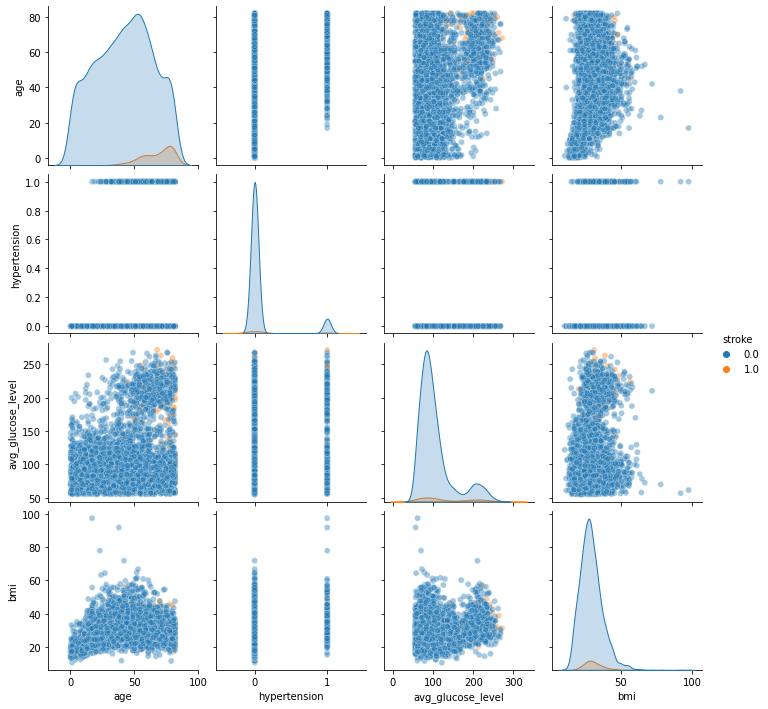

In [21]:
sns.pairplot(df_filled[['age','hypertension','avg_glucose_level','bmi','stroke']], hue='stroke',
             plot_kws={'alpha':0.4})

## Dealing with Class imbalance

In [22]:
df_filled.head()

,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke,Male,married_Yes,Never_worked,Private,Self-employed,children,Urban,formerly smoked,smokes
0,67.0,0.0,1.0,228.69,36.6,1.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1,0
1,61.0,0.0,0.0,202.21,33.8,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0,0
2,80.0,0.0,1.0,105.92,32.5,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0,0
3,49.0,0.0,0.0,171.23,34.4,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0,1
4,79.0,1.0,0.0,174.12,24.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0,0


In [23]:
#splitting data with stratify
X_train, X_test, y_train, y_test = train_test_split(df_filled.drop('stroke', axis=1), df_filled.loc[:,'stroke'],
                                                    test_size = 0.2, random_state=42, stratify = df_filled.loc[:,'stroke'])

In [45]:
#simple logistic regression
#scaling data
std_scale = StandardScaler()

X_train_scaled = std_scale.fit_transform(X_train)
X_test_scaled = std_scale.fit_transform(X_test)

lm = LogisticRegression()
lm.fit(X_train_scaled, y_train)

y_pred = lm.predict(X_test_scaled) 

print('Logistic Regression on Unchanged Train Data; \
        Accuracy: %.3f, \
        Test F1: %.3f, \
        Test Precision: %.3f, \
        Test Recall: %.3f' % \
      (accuracy_score(y_test, y_pred),
      f1_score(y_test, y_pred),
      precision_score(y_test, y_pred),
      recall_score(y_test, y_pred)))

Logistic Regression on Unchanged Train Data;         Accuracy: 0.952,         Test F1: 0.039,         Test Precision: 1.000,         Test Recall: 0.020


(0.0, 1.0)

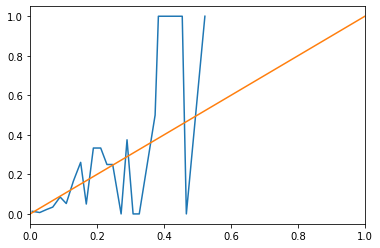

In [74]:
#Reliability Diagram
#https://towardsdatascience.com/how-to-enforce-the-outcome-of-your-ml-classifiers-b5f6163d68c2
from sklearn.calibration import calibration_curve

y_pred_proba = lm.predict_proba(X_test_scaled)

observed_pos_frequency, mean_pred_proba  = calibration_curve(y_test, y_pred_proba[:,1], 
                                                             n_bins=50, strategy='uniform')
plt.plot(mean_pred_proba, observed_pos_frequency)
plt.plot([0, 1], [0, 1])
plt.xlim(0, 1)

#### Oversampling

In [254]:
#oversampling data
import imblearn.over_sampling

f1_scores, prec_scores, rec_scores, acc_scores, ratios = [], [], [], [], []
f1_scores_smote, prec_scores_smote, rec_scores_smote, acc_scores_smote = [], [], [], []
for n in np.arange(1,21):
    # setup for the ratio argument of RandomOverSampler initialization
    n_pos = np.sum(y_train == 1)
    n_neg = np.sum(y_train == 0)
    ratio = {1 : n_pos * n, 0 : n_neg} 

    # randomly oversample positive samples:
    ROS = imblearn.over_sampling.RandomOverSampler(sampling_strategy = ratio, random_state=42) 
    
    # SMOTE oversample positive samples:
    smote = imblearn.over_sampling.SMOTE(sampling_strategy=ratio, random_state = 42)
    
    # transform the dataset
    X_tr_rs, y_tr_rs = ROS.fit_resample(X_train_scaled, y_train)
    X_tr_smote, y_tr_smote = smote.fit_resample(X_train_scaled, y_train)
    
    #random oversample train model
    lm_os = LogisticRegression() 
    lm_os.fit(X_tr_rs, y_tr_rs)
    y_pred_os=lm_os.predict(X_test_scaled)
    
    #smote oversample train model
    lm_smote = LogisticRegression() 
    lm_smote.fit(X_tr_smote, y_tr_smote)
    y_pred_smote=lm_smote.predict(X_test_scaled)
    
    #random os scores
    ratios.append(n)
    f1_scores.append(f1_score(y_test, y_pred_os))    
    prec_scores.append(precision_score(y_test, y_pred_os))
    rec_scores.append(recall_score(y_test, y_pred_os))
    acc_scores.append(accuracy_score(y_test, y_pred_os))
    
    #smote os scores
    f1_scores_smote.append(f1_score(y_test, y_pred_smote))    
    prec_scores_smote.append(precision_score(y_test, y_pred_smote))
    rec_scores_smote.append(recall_score(y_test, y_pred_smote))
    acc_scores_smote.append(accuracy_score(y_test, y_pred_smote))
    
    
    #print('Logistic Regression on Oversampled Train Data; Ratio: %f, Accuracy: %.3f, Test F1: %.3f, Test AUC: %.3f' % \
          #(n, lm_os.score(X_test_scaled, y_test), f1_score(y_test, lm_os.predict(X_test_scaled)), 
           #roc_auc_score(y_test, lm_os.predict_proba(X_test_scaled)[:,1])))

Logistic Regression Model best F1 score 0.333 at ratio 7.000


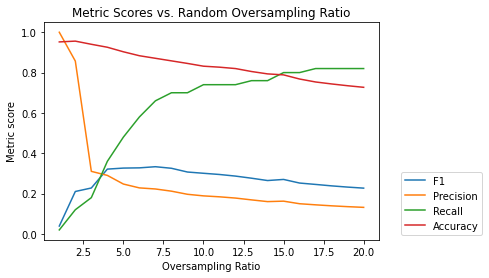

In [195]:
#plot random oversampling results
plt.plot(ratios, f1_scores)
plt.plot(ratios, prec_scores)
plt.plot(ratios, rec_scores)
plt.plot(ratios, acc_scores)

plt.title('Metric Scores vs. Random Oversampling Ratio')
plt.legend(['F1','Precision','Recall','Accuracy'], bbox_to_anchor=(1.05, 0), loc='lower left')
plt.xlabel('Oversampling Ratio')
plt.ylabel('Metric score')

best_f1_score = np.max(f1_scores) 
best_ratio = ratios[np.argmax(f1_scores)]

print('Logistic Regression Model best F1 score %.3f at ratio %.3f' 
      % (best_f1_score, best_ratio))

Logistic Regression Model best F1 score 0.340 at ratio 5.000


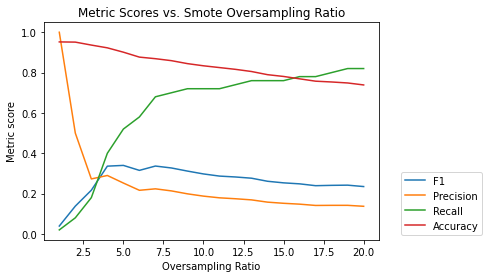

In [196]:
#plot smote oversampling results
plt.plot(ratios, f1_scores_smote)
plt.plot(ratios, prec_scores_smote)
plt.plot(ratios, rec_scores_smote)
plt.plot(ratios, acc_scores_smote)

plt.title('Metric Scores vs. Smote Oversampling Ratio')
plt.legend(['F1','Precision','Recall','Accuracy'], bbox_to_anchor=(1.05, 0), loc='lower left')
plt.xlabel('Oversampling Ratio')
plt.ylabel('Metric score')

best_f1_score = np.max(f1_scores_smote) 
best_ratio = ratios[np.argmax(f1_scores_smote)]

print('Logistic Regression Model best F1 score %.3f at ratio %.3f' 
      % (best_f1_score, best_ratio))

#### Undersampling

In [199]:
from imblearn import under_sampling

In [202]:
# randomly undersample negative samples:            
RUS = imblearn.under_sampling.RandomUnderSampler(random_state=42, sampling_strategy='majority')

# neighborhoodcleaning undersample negative samples:    
neighborcleaning = imblearn.under_sampling.NeighbourhoodCleaningRule(sampling_strategy='majority',n_neighbors=20)

# transform the dataset
X_tr_us, y_tr_us = RUS.fit_resample(X_train_scaled, y_train)
X_tr_nb, y_tr_nb = neighborcleaning.fit_resample(X_train_scaled, y_train)

#random oversample train model
lm_us = LogisticRegression() 
lm_us.fit(X_tr_us, y_tr_us)
y_pred_us=lm_os.predict(X_test_scaled)

#nb oversample train model
lm_nb = LogisticRegression() 
lm_nb.fit(X_tr_nb, y_tr_nb)
y_pred_nb=lm_nb.predict(X_test_scaled)

print('Logistic Regression on Randomly Undersampled Train Data; \
        Accuracy: %.3f, \
        Test F1: %.3f, \
        Test Precision: %.3f, \
        Test Recall: %.3f' % \
      (accuracy_score(y_test, y_pred_us),
      f1_score(y_test, y_pred_us),
      precision_score(y_test, y_pred_us),
      recall_score(y_test, y_pred_us)))
      
print('Logistic Regression on NeighborhoodCleaning Undersampled Train Data; \
        Accuracy: %.3f, \
        Test F1: %.3f, \
        Test Precision: %.3f, \
        Test Recall: %.3f' % \
      (accuracy_score(y_test, y_pred_nb),
      f1_score(y_test, y_pred_nb),
      precision_score(y_test, y_pred_nb),
      recall_score(y_test, y_pred_nb)))


Logistic Regression on Randomly Undersampled Train Data;         Accuracy: 0.727,         Test F1: 0.227,         Test Precision: 0.132,         Test Recall: 0.820
Logistic Regression on NeighborhoodCleaning Undersampled Train Data;         Accuracy: 0.858,         Test F1: 0.300,         Test Precision: 0.197,         Test Recall: 0.620


In [206]:
#testing undersampling parameters
f1_scores_nb, prec_scores_nb, rec_scores_nb, acc_scores_nb, neighbors = [], [], [], [], []
for n in np.arange(1,21):

    # neighborhoodcleaning undersample negative samples:    
    neighborcleaning = imblearn.under_sampling.NeighbourhoodCleaningRule(sampling_strategy='majority',n_neighbors=n)

    # transform the dataset
    X_tr_nb, y_tr_nb = neighborcleaning.fit_resample(X_train_scaled, y_train)

    #nb oversample train model
    lm_nb = LogisticRegression() 
    lm_nb.fit(X_tr_nb, y_tr_nb)
    y_pred_nb=lm_nb.predict(X_test_scaled)
    
    #nb us scores
    neighbors.append(n)
    f1_scores_nb.append(f1_score(y_test, y_pred_nb))    
    prec_scores_nb.append(precision_score(y_test, y_pred_nb))
    rec_scores_nb.append(recall_score(y_test, y_pred_nb))
    acc_scores_nb.append(accuracy_score(y_test, y_pred_nb))    
    
#     print('Logistic Regression on NeighborhoodCleaning Undersampled Train Data; \
#             Accuracy: %.3f, \
#             Test F1: %.3f, \
#             Test Precision: %.3f, \
#             Test Recall: %.3f' % \
#           (accuracy_score(y_test, y_pred_nb),
#           f1_score(y_test, y_pred_nb),
#           precision_score(y_test, y_pred_nb),
#           recall_score(y_test, y_pred_nb)))

Logistic Regression Model best F1 score 0.368 at ratio 11.000


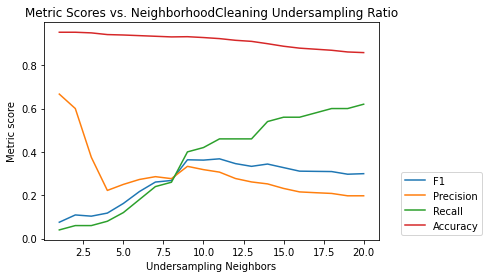

In [212]:
#plot nb undersampling results
plt.plot(neighbors, f1_scores_nb)
plt.plot(neighbors, prec_scores_nb)
plt.plot(neighbors, rec_scores_nb)
plt.plot(neighbors, acc_scores_nb)

plt.title('Metric Scores vs. NeighborhoodCleaning Undersampling Ratio')
plt.legend(['F1','Precision','Recall','Accuracy'], bbox_to_anchor=(1.05, 0), loc='lower left')
plt.xlabel('Undersampling Neighbors')
plt.ylabel('Metric score')

best_f1_score = np.max(f1_scores_nb) 
best_ratio = neighbors[np.argmax(f1_scores_nb)]

print('Logistic Regression Model best F1 score %.3f at ratio %.3f' 
      % (best_f1_score, best_ratio))

#### Class Weights

In [208]:
#balanced class weights
lr_balanced = LogisticRegression(class_weight='balanced')
#lr_4x = LogisticRegression(class_weight={1 : 4, 0 : 1}, solver='liblinear')


lr_balanced.fit(X_train_scaled, y_train)
# print('Balanced class weights Logistic Regression Test F1: %.3f, Test AUC: %.3f' % \
#       (f1_score(y_te, lr_balanced.predict(X_te)), roc_auc_score(y_te, lr_balanced.predict_proba(X_te)[:,1])))

y_pred_cwb=lr_balanced.predict(X_test_scaled)

# lr_4x.fit(X_tr, y_tr)
# print('4:1 class weights Logistic Regression Test F1: %.3f, Test AUC: %.3f' % \
#       (f1_score(y_te, lr_4x.predict(X_te)), roc_auc_score(y_te, lr_4x.predict_proba(X_te)[:,1])))

print('Logistic Regression on Balanced Class Weights Train Data; \
        Accuracy: %.3f, \
        Test F1: %.3f, \
        Test Precision: %.3f, \
        Test Recall: %.3f' % \
      (accuracy_score(y_test, y_pred_cwb),
      f1_score(y_test, y_pred_cwb),
      precision_score(y_test, y_pred_cwb),
      recall_score(y_test, y_pred_cwb)))

Logistic Regression on Balanced Class Weights Train Data;         Accuracy: 0.734,         Test F1: 0.232,         Test Precision: 0.135,         Test Recall: 0.820


In [217]:
#testing classweights parameters
f1_scores_cw, prec_scores_cw, rec_scores_cw, acc_scores_cw, classweights = [], [], [], [], []
for n in np.arange(1,21):

    #cw train model
    lm_cw = LogisticRegression(class_weight={1 : n, 0 : 1}) 
    lm_cw.fit(X_train_scaled, y_train)
    y_pred_cw=lm_cw.predict(X_test_scaled)
    
    #nb us scores
    classweights.append(n)
    f1_scores_cw.append(f1_score(y_test, y_pred_cw))    
    prec_scores_cw.append(precision_score(y_test, y_pred_cw))
    rec_scores_cw.append(recall_score(y_test, y_pred_cw))
    acc_scores_cw.append(accuracy_score(y_test, y_pred_cw))    
    
#     print('Logistic Regression on Classweighted Train Data; \
#             Accuracy: %.3f, \
#             Test F1: %.3f, \
#             Test Precision: %.3f, \
#             Test Recall: %.3f' % \
#           (accuracy_score(y_test, y_pred_cw),
#           f1_score(y_test, y_pred_cw),
#           precision_score(y_test, y_pred_cw),
#           recall_score(y_test, y_pred_cw)))

Logistic Regression Model best F1 score 0.345 at ratio 7.000


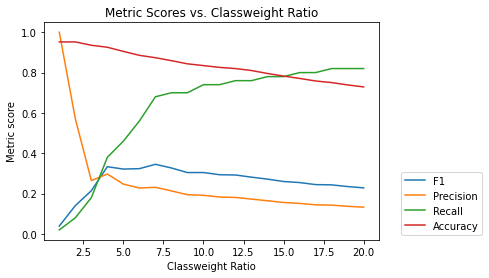

In [213]:
#plot classweighted results
plt.plot(classweights, f1_scores_cw)
plt.plot(classweights, prec_scores_cw)
plt.plot(classweights, rec_scores_cw)
plt.plot(classweights, acc_scores_cw)

plt.title('Metric Scores vs. Classweight Ratio')
plt.legend(['F1','Precision','Recall','Accuracy'], bbox_to_anchor=(1.05, 0), loc='lower left')
plt.xlabel('Classweight Ratio')
plt.ylabel('Metric score')

best_f1_score = np.max(f1_scores_cw) 
best_ratio = classweights[np.argmax(f1_scores_cw)]

print('Logistic Regression Model best F1 score %.3f at ratio %.3f' 
      % (best_f1_score, best_ratio))

# Exhaustive GridSearch

In [63]:
from sklearn.model_selection import GridSearchCV
from sklearn.calibration import CalibratedClassifierCV

In [26]:
import warnings
warnings.filterwarnings('ignore')
#warnings.simplefilter('always')

#### Logistic Regression

In [69]:
#Logistic Regression GridSearchCV

from imblearn.pipeline import Pipeline

classweights=[]
for n in np.arange(1,11):
    classweights.append({1 : n, 0 : 1})

penalty=['l1', 'l2', 'elasticnet'] 

ratios=[]
for n in np.arange(1,10):
    # setup for the ratio argument of RandomOverSampler initialization
    n_pos = np.sum(y_train == 1)
    n_neg = np.sum(y_train == 0)
    ratios.append({1 : n_pos * n, 0 : n_neg})

method=['sigmoid', 'isotonic']    

calibrated_lr = CalibratedClassifierCV(base_estimator=LogisticRegression())    
    
lr_pipe = Pipeline([
        ('stds', StandardScaler()),
        #('oversampling', imblearn.over_sampling.SMOTE()),
        #('undersampling', imblearn.under_sampling.NeighbourhoodCleaningRule()),
        ('calibrated_lr', calibrated_lr)
        ])

params = [{#'oversampling__sampling_strategy':ratios,
           #'oversampling__random_state':[42],
    #'undersampling__sampling_strategy':['majority'],
    #'undersampling__n_neighbors':np.arange(1,15),
    'calibrated_lr__base_estimator__C': np.logspace(0.001, 10, 10),
    'calibrated_lr__base_estimator__class_weight':classweights,
    'calibrated_lr__base_estimator__penalty':penalty,
    'calibrated_lr__method':method
          }]

gs_lr = GridSearchCV(lr_pipe,
                     param_grid=params,
                     scoring='f1',
                     refit='f1',
                     cv=5,
                     n_jobs=-1)

gs_lr.fit(X_train, y_train)
y_pred_gs=gs_lr.predict(X_test)

print(gs_lr.best_params_)
print(gs_lr.best_score_)

{'calibrated_lr__base_estimator__C': 1.0023052380778996, 'calibrated_lr__base_estimator__class_weight': {1: 3, 0: 1}, 'calibrated_lr__base_estimator__penalty': 'l2', 'calibrated_lr__method': 'isotonic'}
0.009756097560975611


In [70]:
#Logistic Regression on Testing set
y_pred_gs=gs_lr.predict(X_test)

# lr_4x.fit(X_tr, y_tr)
# print('4:1 class weights Logistic Regression Test F1: %.3f, Test AUC: %.3f' % \
#       (f1_score(y_te, lr_4x.predict(X_te)), roc_auc_score(y_te, lr_4x.predict_proba(X_te)[:,1])))

print('Logistic Regression on Balanced Class Weights Train Data; \
        Accuracy: %.3f, \
        Test F1: %.3f, \
        Test Precision: %.3f, \
        Test Recall: %.3f' % \
      (accuracy_score(y_test, y_pred_gs),
      f1_score(y_test, y_pred_gs),
      precision_score(y_test, y_pred_gs),
      recall_score(y_test, y_pred_gs)))

Logistic Regression on Balanced Class Weights Train Data;         Accuracy: 0.952,         Test F1: 0.075,         Test Precision: 0.667,         Test Recall: 0.040


In [71]:
#brier score
from sklearn.metrics import brier_score_loss

y_pred_gs_proba=gs_lr.predict_proba(X_test)

brier_loss = brier_score_loss(y_test, y_pred_gs_proba[:,1])

print('Logistic Regression on Test Data; \
        Brier: %.3f,' % \
      (brier_loss))

Logistic Regression on Test Data;         Brier: 0.041,


(0.0, 1.0)

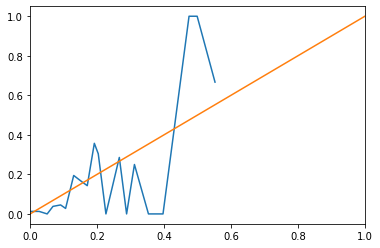

In [73]:
#Reliability Diagram
#https://towardsdatascience.com/how-to-enforce-the-outcome-of-your-ml-classifiers-b5f6163d68c2
from sklearn.calibration import calibration_curve

observed_pos_frequency, mean_pred_proba  = calibration_curve(y_test, y_pred_gs_proba[:,1], 
                                                             n_bins=50, strategy='uniform')
plt.plot(mean_pred_proba, observed_pos_frequency)
plt.plot([0, 1], [0, 1])
plt.xlim(0,1)

#### KNN

In [82]:
#KNN GridSearchCV
from imblearn import under_sampling
from imblearn import over_sampling


ratios=[]
for n in np.arange(1,10):
    # setup for the ratio argument of RandomOverSampler initialization
    n_pos = np.sum(y_train == 1)
    n_neg = np.sum(y_train == 0)
    ratios.append({1 : n_pos * n, 0 : n_neg})

calibrated_knn = CalibratedClassifierCV(base_estimator=KNeighborsClassifier())        
    
knn_pipe = Pipeline([
        ('stds', StandardScaler()),
        #('oversampling', imblearn.over_sampling.SMOTE()),
        ('undersampling', under_sampling.NeighbourhoodCleaningRule()),
        ('calibrated_knn', calibrated_knn)
        ])

params = [{#'oversampling__sampling_strategy':ratios,
           #'oversampling__random_state':[42],
    'undersampling__sampling_strategy':['majority'],
    'undersampling__n_neighbors':np.arange(1,15),
    'calibrated_knn__base_estimator__n_neighbors': np.arange(1, 20, 2),
    'calibrated_knn__base_estimator__weights':['uniform', 'distance'],
    'calibrated_knn__method':method
          }]

gs_knn = GridSearchCV(knn_pipe,
                     param_grid=params,
                     scoring='f1',
                     refit='f1',
                     cv=5,
                     n_jobs=-1)

gs_knn.fit(X_train, y_train)
y_pred_gs=gs_knn.predict(X_test)

print(gs_knn.best_params_)
print(gs_knn.best_score_)

{'calibrated_knn__base_estimator__n_neighbors': 15, 'calibrated_knn__base_estimator__weights': 'uniform', 'calibrated_knn__method': 'isotonic', 'undersampling__n_neighbors': 13, 'undersampling__sampling_strategy': 'majority'}
0.23012450409792748


In [83]:
#KNN on Testing set
y_pred_gs=gs_knn.predict(X_test)

# lr_4x.fit(X_tr, y_tr)
# print('4:1 class weights Logistic Regression Test F1: %.3f, Test AUC: %.3f' % \
#       (f1_score(y_te, lr_4x.predict(X_te)), roc_auc_score(y_te, lr_4x.predict_proba(X_te)[:,1])))

print('KNN on Balanced Class Weights Train Data; \
        Accuracy: %.3f, \
        Test F1: %.3f, \
        Test Precision: %.3f, \
        Test Recall: %.3f' % \
      (accuracy_score(y_test, y_pred_gs),
      f1_score(y_test, y_pred_gs),
      precision_score(y_test, y_pred_gs),
      recall_score(y_test, y_pred_gs)))

KNN on Balanced Class Weights Train Data;         Accuracy: 0.905,         Test F1: 0.248,         Test Precision: 0.203,         Test Recall: 0.320


In [84]:
#brier score
from sklearn.metrics import brier_score_loss

y_pred_gs_proba=gs_knn.predict_proba(X_test)

brier_loss = brier_score_loss(y_test, y_pred_gs_proba[:,1])

print('KNN on Test Data; \
        Brier: %.3f,' % \
      (brier_loss))

KNN on Test Data;         Brier: 0.079,


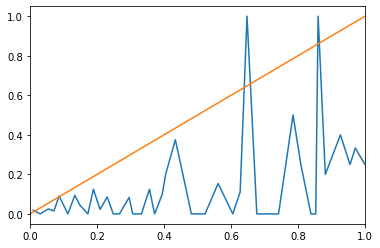

In [85]:
#Reliability Diagram
#https://towardsdatascience.com/how-to-enforce-the-outcome-of-your-ml-classifiers-b5f6163d68c2
from sklearn.calibration import calibration_curve

observed_pos_frequency, mean_pred_proba  = calibration_curve(y_test, y_pred_gs_proba[:,1], 
                                                             n_bins=50, strategy='uniform')
plt.plot(mean_pred_proba, observed_pos_frequency)
plt.plot([0, 1], [0, 1])
plt.xlim(0,1)
plt.show()